Colorspace and architecture: https://arxiv.org/abs/2204.02850  
Fully Convolutional Networks: https://arxiv.org/pdf/1411.4038.pdf

Jetson nano: 0.236 TFLOPS fp32

Image colorization on youtube: https://youtu.be/WXyeQeHUxpc?si=jQfcU8Ra4StxFOwT

Youtube code: https://colab.research.google.com/drive/1BsqM7GBTtsyBixy2jsLGJNiSvp1ocpV7?usp=sharing


In [1]:
#! pip install torchprofile 1>/dev/null
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs # Helps us to obtain mac calculations

import torch.nn.functional as F
import os
from torch.utils.data import Dataset
from PIL import Image
import cv2

print("Testing if GPU is available.")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, Falling back to CPU.")

#os.chdir("/home/aaron/git/ImageColorization/")
BASEADDR = os.getcwd()
print(f"Current working directory: {BASEADDR}")

BATCH_SIZE = 64


C:\Users\kja12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing if GPU is available.
GPU is available and being used.
Current working directory: d:\Github2\ImageColorization


Convert video to frames

In [3]:
def saveframes(video_path, dir_path, basename, ext='jpg'):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    n = 0

    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
            n += 1
        else:
            return

#saveframes('data/temp/sample_video.mp4', 'data/temp/result', 'sample_video_img')

# Download and unpack imagenet64 database
imagenet64 is the imagenet database with each image scaled to be 64 by 64 pixels.

In [5]:
checkpoints = f"{BASEADDR}/checkpoints/"
content = f"{BASEADDR}/content/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

import shutil
if not os.path.exists(f'{content}/imagenet64'):
  if not os.path.exists(content + 'imagenet64.zip'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    #!wget https://pjreddie.com/media/files/imagenet64.tar

  if not os.path.exists(content):
    os.makedirs(content)
  os.chdir(content)
  print("Copying to local runtime...")
  shutil.copy(checkpoints + 'imagenet64.zip', './imagenet64.zip')
  print("Uncompressing...")
  #!tar -xf imagenet64.tar

print("Data ready!")


Data ready!


Download an unpack full scale imagenet dataset

In [3]:
checkpoints = f"{BASEADDR}/checkpoints/"
fullcontent = f"{BASEADDR}/fullcontent/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

import shutil
if not os.path.exists(f'{fullcontent}/imagenet'):
  if not os.path.exists(fullcontent + 'imagenet.zip'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    #!wget https://pjreddie.com/media/files/imagenet64.tar

  if not os.path.exists(fullcontent):
    os.makedirs(fullcontent)
  os.chdir(fullcontent)
  print("Copying to local runtime...")
  #shutil.copy(checkpoints + 'imagenet.zip', './imagenet.zip')
  print("Uncompressing...")
  #!tar -xf imagenet64.tar

print("Data ready!")

Data ready!


In [7]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load color image
        color_img, _ = self.dataset[idx]

        # Convert color image to grayscale
        gray = transforms.Grayscale()
        #grayscale_img = gray(color_img)
        grayscale_img = torch.cat((gray(color_img),gray(color_img),gray(color_img))) #adjusted for vgg

        return grayscale_img, color_img


Get Dataset for full scale imagenet

In [31]:
def get_imagenet_data(batchSize):
  ## transformations


  transform=transforms.Compose([
                             transforms.RandomResizedCrop(160, scale=(1.0, 1.0), ratio=(1., 1.)),
                              transforms.RandomHorizontalFlip(),
                              #transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ])

  ## download and load training dataset
  trainSet = torchvision.datasets.ImageFolder(root=f'{fullcontent}imagenet/train/', transform=transform)
  subset = 600000 # Delete this line after debug
  trainSet, _ = torch.utils.data.random_split(trainSet, [subset, len(trainSet)-subset]) # Delete this line after debug
  colorizationTrainSet = ColorizationDataset(trainSet)
  trainLoader = DataLoader(colorizationTrainSet, batch_size=batchSize, shuffle=True, num_workers=0)

  ## download and load testing dataset
  testSet = torchvision.datasets.ImageFolder(root=f'{fullcontent}imagenet/test/', transform=transform)
  subset = 5000
  testSet, _ = torch.utils.data.random_split(testSet, [subset, len(testSet)-subset]) # Delete this line after debug
  colorizationTestSet = ColorizationDataset(testSet)
  testloader = torch.utils.data.DataLoader(colorizationTestSet, batch_size=batchSize, shuffle=False, num_workers=0)
  return {'train': trainLoader, 'test': testloader}

Get dataset for imagenet64

In [38]:
def get_imagenet64_data(batchSize):
  ## transformations

  transform=transforms.Compose([
                             transforms.RandomResizedCrop(64, scale=(1.0, 1.0), ratio=(1., 1.)),
                              transforms.RandomHorizontalFlip(),
                              #transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ])

  ## download and load training dataset
  trainSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/train/', transform=transform)
  #subset = 800000 # Delete this line after debug
  #trainSet, _ = torch.utils.data.random_split(trainSet, [subset, len(trainSet)-subset]) # Delete this line after debug
  colorizationTrainSet = ColorizationDataset(trainSet)
  trainLoader = DataLoader(colorizationTrainSet, batch_size=batchSize, shuffle=True, num_workers=0)

  ## download and load testing dataset
  testSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/val/', transform=transform)
  #subset = 10000
  #testSet, _ = torch.utils.data.random_split(testSet, [subset, len(testSet)-subset]) # Delete this line after debug
  colorizationTestSet = ColorizationDataset(testSet)
  testloader = torch.utils.data.DataLoader(colorizationTestSet, batch_size=batchSize, shuffle=False, num_workers=0)
  return {'train': trainLoader, 'test': testloader}

In [2]:
# Adjusted network to match VGG13
class GrayNet(nn.Module):
    def __init__(self):
        super(GrayNet, self).__init__()
        channels = 64
        #block 1
        self.conv1 = nn.Conv2d(3, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

        #block 2
        self.conv3 = nn.Conv2d(channels, channels*2, 3, padding=1)
        self.conv4 = nn.Conv2d(channels*2, channels*2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels*2)
        self.bn4 = nn.BatchNorm2d(channels*2)

        #block 3
        self.conv5 = nn.Conv2d(channels*2, channels*4, 3, padding=1)
        self.conv6 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(channels*4)
        self.bn6 = nn.BatchNorm2d(channels*4)

        #block 4
        self.conv7 = nn.Conv2d(channels*4, channels*8, 3, padding=1)
        self.conv8 = nn.Conv2d(channels*8, channels*8, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(channels*8)
        self.bn8 = nn.BatchNorm2d(channels*8)

        #block 5
        self.conv9 = nn.Conv2d(channels*8, channels*8, 3, padding=1)
        self.conv10 = nn.Conv2d(channels*8, channels*8, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(channels*8)
        self.bn10 = nn.BatchNorm2d(channels*8)
        self.conv11 = nn.ConvTranspose2d(channels*8,channels*8, kernel_size=2,stride=2)

        #block 6
        self.conv12 = nn.Conv2d(channels*16, channels*4, 1, padding=0)
        self.conv13 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.conv14 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(channels*4)
        self.bn13 = nn.BatchNorm2d(channels*4)
        self.bn14 = nn.BatchNorm2d(channels*4)
        self.conv15 = nn.ConvTranspose2d(channels*4,channels*4, kernel_size=2,stride=2)

        #block 7
        self.conv16 = nn.Conv2d(channels*8, channels*2, 1, padding=0)
        self.conv17 = nn.Conv2d(channels*2, channels*2, 3, padding=1)
        self.conv18 = nn.Conv2d(channels*2, channels*2, 3, padding=1)
        self.bn16 = nn.BatchNorm2d(channels*2)
        self.bn17 = nn.BatchNorm2d(channels*2)
        self.bn18 = nn.BatchNorm2d(channels*2)
        self.conv19 = nn.ConvTranspose2d(channels*2,channels*2, kernel_size=2,stride=2)

        #block 8
        self.conv20 = nn.Conv2d(channels*4, channels, 1, padding=0)
        self.conv21 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv22 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn20 = nn.BatchNorm2d(channels)
        self.bn21 = nn.BatchNorm2d(channels)
        self.bn22 = nn.BatchNorm2d(channels)
        self.conv23 = nn.ConvTranspose2d(channels,channels, kernel_size=2,stride=2)

        #block 9
        self.conv24 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv25 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv26 = nn.Conv2d(channels, 3, 3, padding=1)
        self.bn24 = nn.BatchNorm2d(channels)
        self.bn25 = nn.BatchNorm2d(channels)
        self.bn26 = nn.BatchNorm2d(3)

    def forward(self, x):
        #print(x.size())
        # Input 64x64x3
        #block1
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))) # 32x32xchannels
        block1 = x
        x = F.max_pool2d(x,2)
        
        #block2
        x = F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))) # 16x16xchannels*2
        block2 = x
        x = F.max_pool2d(x,2)
        
        #block3
        x = F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(x)))))) # 8x8xchannels*4
        block3 = x
        x = F.max_pool2d(x,2)
        
        #block4
        x = F.relu(self.bn8(self.conv8(F.relu(self.bn7(self.conv7(x)))))) # 4x4xchannels*8
        block4 = x
        x = F.max_pool2d(x,2)
        
        #block5
        x = self.conv11(F.relu(self.bn10(self.conv10(F.relu(self.bn9(self.conv9(x))))))) # 8x8xchannels*8
        
        #block6
        x = torch.cat((x,block4),1) #8x8xchannels*16
        x = self.conv15(F.relu(self.bn14(self.conv14(F.relu(self.bn13(self.conv13(F.relu(self.bn12(self.conv12(x)))))))))) #16x16xchannels*4
        
        #block7
        x =torch.cat((x,block3),1)#16x16xchannels*8
        x = self.conv19(F.relu(self.bn18(self.conv18(F.relu(self.bn17(self.conv17(F.relu(self.bn16(self.conv16(x)))))))))) #32x32xchannels*2
        
        #block8
        x =torch.cat((x,block2),1) #32x32xchannels*4
        x = self.conv23(F.relu(self.bn22(self.conv22(F.relu(self.bn21(self.conv21(F.relu(self.bn20(self.conv20(x)))))))))) #64x64xchannels
        
        #block9
        x = F.relu(self.bn26(self.conv26(F.relu(self.bn25(self.conv25(F.relu(self.bn24(self.conv24(x))))))))) #64x64x3 RGB
        return x

Function to colorize video

In [3]:
def ColorizeVideo(model, inputpath, outputpath):
    vidIn = cv2.VideoCapture(inputpath)
    #vidOut = cv2.VideoWriter(outputpath,cv2.VideoWriter_fourcc(*'DIVX'), 30,)
    if not vidIn.isOpened():
        print('vidin not opened')
        return
    

    flag = True
    while True:
        ret, frame = vidIn.read()
        if flag:
            height, width, layers = frame.shape
            size = (width,height)
            vidOut = cv2.VideoWriter(outputpath,cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
            flag = False
        if ret:
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB).transpose(2,0,1)
            frame = torch.from_numpy(frame).to(device)
            frame = model(frame.type(torch.FloatTensor).to(device).unsqueeze(0))
            vidOut.write(cv2.cvtColor(frame.cpu().detach().numpy().squeeze(0).transpose(1,2,0),cv2.COLOR_RGB2BGR))
        else:
            vidOut.release()
            return

Load video and input to network

In [6]:
model = GrayNet().to(device)
loadPath = f"{checkpoints}largeimagetrainedweights.pt"
model.load_state_dict(torch.load(loadPath))
inputpath = f"{BASEADDR}\\grayscale_video\\AndygriffithLake Cropped 480p.mp4"
outputpath = f"{BASEADDR}\\colorized_video\\AndygriffithLake Cropped 480p.avi"
ColorizeVideo(model, inputpath,outputpath)

### Test network sizes.

In [32]:
testInput = torch.randn(1,3,256,256).to(device)

testNetwork = GrayNet().to(device)
testNetwork(testInput)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3954,  ..., 0.0000, 0.0124, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.0861, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.4048, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0691, 0.0000, 0.0000,  ..., 0.0000, 1.1099, 0.1041],
          [0.0000, 0.0000, 1.0431,  ..., 0.0000, 0.0000, 0.8417],
          ...,
          [1.1760, 0.6368, 0.5963,  ..., 0.0000, 0.4805, 0.3346],
          [0.4723, 0.0000, 0.0000,  ..., 0.4611, 0.7010, 0.2431],
          [0.5169, 1.1411, 0.0000,  ..., 0.7514, 0.0000, 0.3188]],

         [[1.4592, 0.5830, 0.0000,  ..., 0.4407, 1.2835, 0.4443],
          [0.7874, 1.1294, 0.0000,  ..., 1.2160, 0.0000, 0.0000],
          [0.7116, 0.0000, 0.9848,  ..., 0

### Get the networks MACs and size.

In [33]:
#Model size
def get_model_macs(model, inputs) -> int:
  # We iimported profile_macs in the necessary packages loaded
    return profile_macs(model, inputs)

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB


In [34]:
model_size = get_model_size(testNetwork)
print(f"model has size={model_size/MiB:.2f} MiB")
macs = get_model_macs(testNetwork,testInput)
latency = (macs*2)/(0.236*10**12)
fps = latency**-1
print(macs)
print(latency)
print(fps)


model has size=48.74 MiB
28308078592
0.23989897111864406
4.1684213789539


In [7]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  #scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  #scheduler.step()

In [8]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  verbose=True,
) -> float:
  model.eval()

  loss = 0

  for inputs, targets in tqdm(dataloader, leave=False, disable= not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    loss += criterion(outputs, targets).item()

  return loss

# Initialize model and load pretrained weights.

In [13]:
model = GrayNet().to(device)
# Load pretrained weights into the decoder portion of the network
pre = torchvision.models.vgg13_bn(weights = torchvision.models.VGG13_BN_Weights).to(device)
params = pre.features[0].state_dict()
model.conv1.load_state_dict(params)
model.conv1.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[3].state_dict()
model.conv2.load_state_dict(params)
model.conv2.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[7].state_dict()
model.conv3.load_state_dict(params)
model.conv3.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[10].state_dict()
model.conv4.load_state_dict(params)
model.conv4.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[14].state_dict()
model.conv5.load_state_dict(params)
model.conv5.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[17].state_dict()
model.conv6.load_state_dict(params)
model.conv6.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[21].state_dict()
model.conv7.load_state_dict(params)
model.conv7.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[24].state_dict()
model.conv8.load_state_dict(params)
model.conv8.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[28].state_dict()
model.conv9.load_state_dict(params)
model.conv9.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later
params = pre.features[31].state_dict()
model.conv10.load_state_dict(params)
model.conv10.requires_grad_ = False  #Freeze layer for transfer learning. May want to unfreeze later



C:\Users\kja12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Save model to file

In [11]:
# Save current model to file
def saveModel(state, savePath):
    if not os.path.exists(os.path.dirname(savePath)):
        os.makedirs(os.path.dirname(savePath))
    torch.save(state, savePath)

#saveModel(model.state_dict(), f"{checkpoints}baselinepretrained.pt")

### Load existing model

In [35]:
# Load model from file.
model = GrayNet().to(device)
loadPath = f"{checkpoints}baselinepretrained.pt"
model.load_state_dict(torch.load(loadPath))
recover_model = lambda: model.load_state_dict(torch.load(loadPath))

### Visualize the data fed into the network

In [20]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

In [ ]:
data = get_imagenet64_data(BATCH_SIZE)
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

In [15]:
data = get_imagenet_data(16)
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

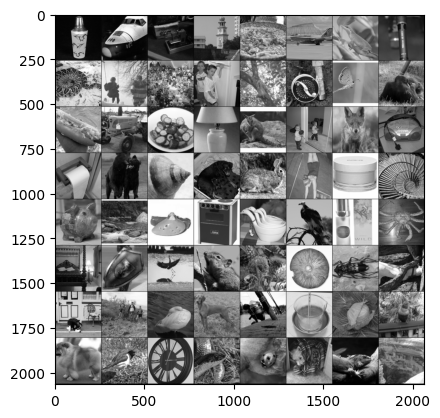

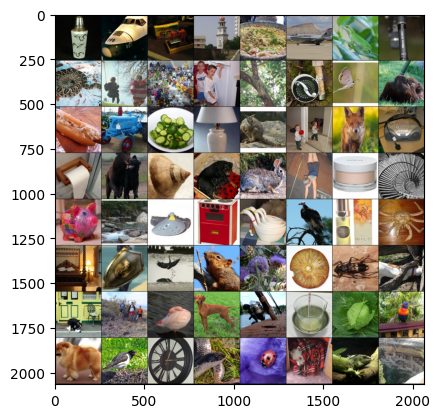

In [49]:
def visualizeData(dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))

visualizeData(trainLoader)

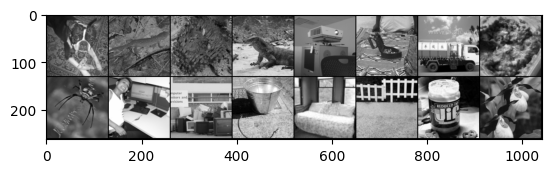

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


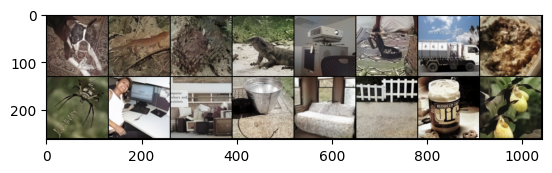

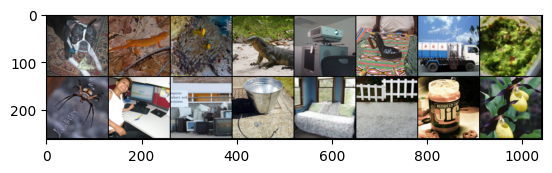

In [24]:
def visualizeNetwork(model: nn.Module, dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))

    # show colorized images.
    outputs = model(inputs.to(device))
    imshow(torchvision.utils.make_grid(outputs.cpu()))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))

visualizeNetwork(model, trainLoader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


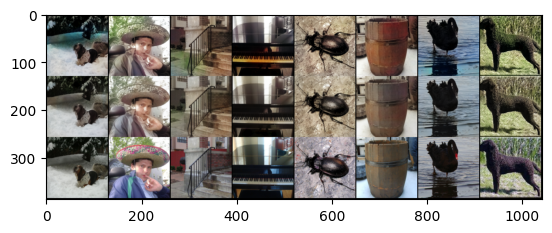

In [23]:
def compareNetworks(model: nn.Module, dataLoader: DataLoader, net1: str, net2: str):
    sampledata = get_imagenet_data(8)
    inputs, targets = next(iter(sampledata['train']))

    # Save original state of model.
    originalState = model.state_dict()

    # get colorized images from networks.
    model.load_state_dict(torch.load(net1))
    outputs1 = model(inputs.to(device))
    model.load_state_dict(torch.load(net2))
    outputs2 = model(inputs.to(device))

    # Display colorized images alongside true image.
    imshow(torchvision.utils.make_grid(torch.cat((outputs1.cpu(), outputs2.cpu(), targets),2)))
    
    # Load original state back into model.
    model.load_state_dict(originalState)

compareNetworks(model, trainLoader, f"{checkpoints}10/11.pt", f"{checkpoints}20/5.pt")

Initialize Dataset Full scale

In [32]:
data = get_imagenet_data(16)
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

Initialize Dataset 64x64

In [39]:
data = get_imagenet64_data(16)
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

### Train the network.

In [40]:
VERSION = 30


lr = 0.00002
lr_step_gamma = 0.8
num_epochs = 1000

optimizer = Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()
#scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_loss = 10000

for epoch in range(num_epochs):
    train(model, trainLoader, criterion, optimizer)
    loss = evaluate(model, testLoader, criterion)
    if loss < best_loss:
        saveModel(model.state_dict(), f"{checkpoints}{VERSION}/{epoch}.pt")
        best_loss = loss
    print(f'    Epoch {epoch+1:>2d} Loss: {loss} | Lowest Loss: {best_loss}')

 99%|█████████▉| 79391/80072 [2:38:58<01:19,  8.61it/s]  

Freeze/Unfreeze pretrained Decoder Layers

In [ ]:
print(model.conv1.requires_grad_)
model.conv1.requires_grad_ =  not model.conv1.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
print(model.conv1.requires_grad_)
model.conv2.requires_grad_ = not model.conv2.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv3.requires_grad_ = not model.conv3.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv4.requires_grad_ = not model.conv4.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv5.requires_grad_ = not model.conv5.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv6.requires_grad_ = not model.conv6.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv7.requires_grad_ = not model.conv7.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv8.requires_grad_ = not model.conv8.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv9.requires_grad_ = not model.conv9.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later
model.conv10.requires_grad_ = not model.conv10.requires_grad_  #Freeze layer for transfer learning. May want to unfreeze later